In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import h5py
import pickle
import constants as cst

import sys
import os
import subprocess
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import kgrid as kgrid
import Photo_Emission as Photo


np.set_printoptions(threshold=np.inf)

In [21]:
system="BlackP"
out_path = "./../../OUT/"
path = "./../../DATA/data_excitons/"+system+"/"

In [22]:
nkx=72
nky=72
nkz=72


#name_Exciton_energy = str(nkx)+'x'+str(nky)+'x'+str(nkz)+'.log'

#result = subprocess.run(['bash','./log_Hqpgw_new/read.sh', './log_Hqpgw_new/'+name_Exciton_energy, 'E(1)', "1"],capture_output=True,text=True)
#E_exciton = float(result.stdout.strip())

fname = path + "BlackP_grid_nk"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_wann_calc.h5"
Energies = Reading.ReadBands(fname)
#Energie_Valence = np.reshape(Energies[:,19],[nkx,nky,nkz])
Energie_no_Valence  = Energies[:,18]
Energie_Valence     = Energies[:,19]
Energie_Conduction  = Energies[:,20]



##estos archivos se deben mover a la carpeta de outputs al final del dia
fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc.h5"
ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)

fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc_dens.h5"

ψ = Reading.Read_Density(fname)

In [23]:
p_ex = np.array([.0,.0,.0])

nuevok = 170

yp = Photo.Interpolator(nkx,nky,nkz,ψ[0,:],nuevok)

#Ψ_k_p   = Photo.SHIFTING_KplusP(nkx,nky,nkz,ψ[0,:],p_ex)
Ψ_k_p   = Photo.SHIFTING_KplusP(nuevok,nuevok,nuevok,yp,p_ex)
Ec_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Conduction,p_ex)
Ev_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,p_ex)
Env_k_p = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_no_Valence,p_ex)

EnergySpectrum = np.linspace(np.min(Energie_Valence)+ϵ[0]-0.01,np.max(Energie_Valence)+ϵ[0]+0.015,800)

tolerancia = 0.0005

In [ ]:
#===========================================================================
k_points_path = np.array([[0.0,0.0,0.0],[0.0,0.0,0.5],[0.5,0.0,0.5],[0.5,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.5]])
n_kpts=80
new_path = kgrid.K_PATH(k_points_path,n_kpts)
#klabel=[r"$\Gamma$","X","S","Y",r"$\Gamma$","X"]

Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)



Intensity = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0])<= tolerancia:
            Intensity[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * np.real(Ψ_kpts[kk])


np.shape(new_path)

In [24]:
#===========================================================================
delta = 0.1
k_points_path = np.array([[-delta,0.0,0.0],[delta,0.0,0.0]])
n_kpts=140
x_kpts = np.linspace(0-delta,0+delta,n_kpts)
new_path = kgrid.K_PATH(k_points_path,n_kpts)

#Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ψ_kpts   = Photo.FourierInterpolate(nuevok,nuevok,nuevok,Ψ_k_p,new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)


Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2))

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        Intensity_E[ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * abs(Ψ_kpts[kk])
        Intensity_E[ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])


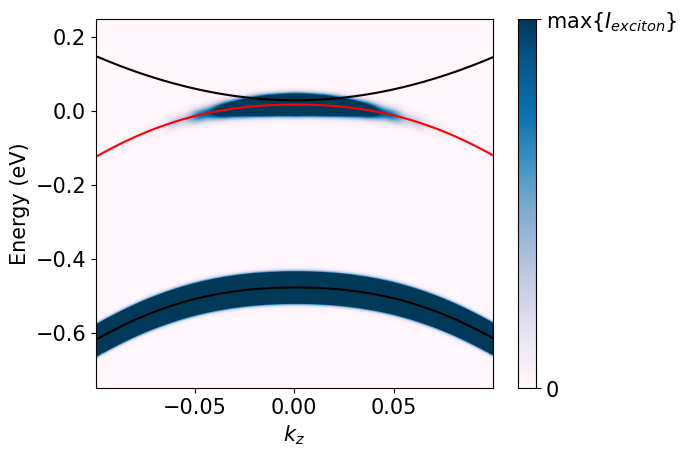

In [27]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
Intensity = IntensityE_plot*10 + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')

cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)



ax1.plot(x_kpts, cst.Ry * Ec_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')
ax1.plot(x_kpts, cst.Ry * Ev_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')
ax1.plot(x_kpts, cst.Ry * (Ev_kpts.reshape(n_kpts,1,1)[:,0,0] + ϵ[0]), c='red')
ax1.plot(x_kpts, cst.Ry * Env_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')

ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_z$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


#plt.savefig("Spectrum_Z.png",bbox_inches='tight')

In [8]:
#===========================================================================
delta = 0.1
k_points_path = np.array([[0.0,-delta,0.0],[0.0,delta,0.0]])
n_kpts=140
y_kpts = np.linspace(0-delta,0+delta,n_kpts)
new_path = kgrid.K_PATH(k_points_path,n_kpts)

#Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ψ_kpts   = Photo.FourierInterpolate(nuevok,nuevok,nuevok,Ψ_k_p,new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)

#print(Ψ_kpts)

Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2),dtype=np.complex_)

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        Intensity_E[ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * abs(Ψ_kpts[kk])
        Intensity_E[ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])


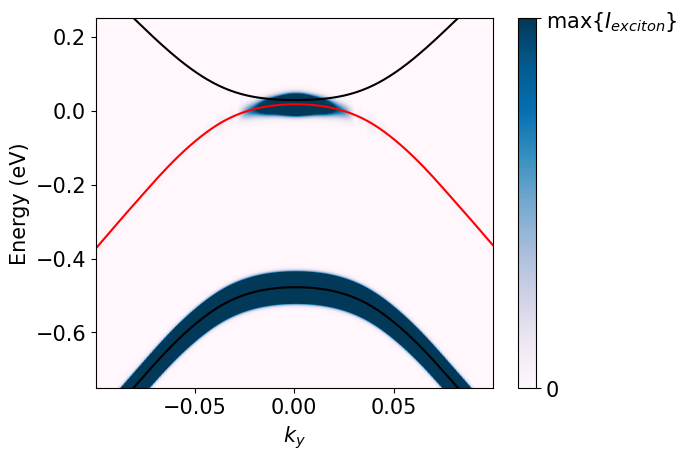

In [11]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),1,n_kpts,1)[:,0,:,0]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),1,n_kpts,1)[:,0,:,0]
Intensity = IntensityE_plot*10 + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[y_kpts.min(),y_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')
cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)  # vertically oriented colorbar

ax1.plot(y_kpts, cst.Ry * Ec_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')
ax1.plot(y_kpts, cst.Ry * Ev_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')
ax1.plot(y_kpts, cst.Ry * (Ev_kpts.reshape(1,n_kpts,1)[0,:,0] + ϵ[0]), c='red')
ax1.plot(y_kpts, cst.Ry * Env_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')

ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_y$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


#plt.savefig("Spectrum_Y.png",bbox_inches='tight')

In [12]:
#===========================================================================
delta = 0.1
k_points_path = np.array([[0.0,0.0,-delta],[0.0,0.0,delta]])
n_kpts=140
z_kpts = np.linspace(0-delta,0+delta,n_kpts)
new_path = kgrid.K_PATH(k_points_path,n_kpts)

#Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ψ_kpts   = Photo.FourierInterpolate(nuevok,nuevok,nuevok,Ψ_k_p,new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)

Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2))

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        Intensity_E[ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * abs(Ψ_kpts[kk])
        Intensity_E[ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])

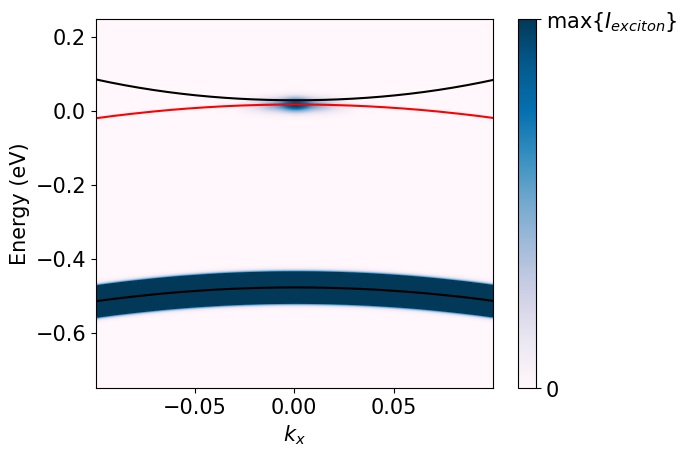

In [13]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),1,1,n_kpts)[:,0,0,:]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),1,1,n_kpts)[:,0,0,:]
Intensity = IntensityE_plot + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[z_kpts.min(),z_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')
cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)  # vertically oriented colorbar

ax1.plot(z_kpts, cst.Ry * Ec_kpts.reshape(1,1,n_kpts)[0,0,:], c='black')
ax1.plot(z_kpts, cst.Ry * Ev_kpts.reshape(1,1,n_kpts)[0,0,:], c='black')
ax1.plot(z_kpts, cst.Ry * (Ev_kpts.reshape(1,1,n_kpts)[0,0,:] + ϵ[0]), c='red')
ax1.plot(z_kpts, cst.Ry * Env_kpts.reshape(1,1,n_kpts)[0,0,:], c='black')

ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_x$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


#plt.savefig("Spectrum_X.png",bbox_inches='tight')

(0.011459149501303223, 0.011459325522823194)

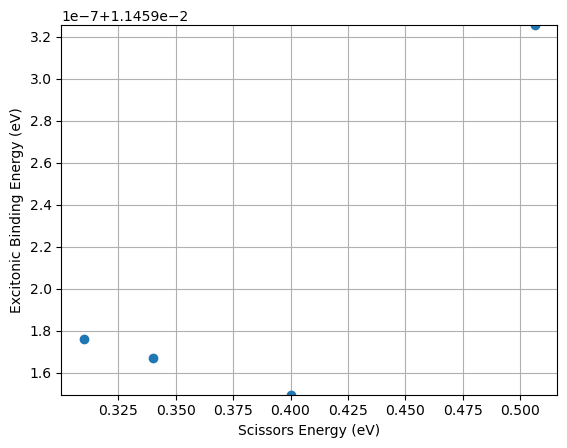

In [59]:
fname="./out_Hqpgw_new/px0.00_py0.00_pz0.00"+"_exc.h5"
ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)
fname="./out_Hqpgw_new/px0.00_py0.00_pz0.00"+"_scissor_-0.40_exc.h5"
ϵ_40,ϕ_real_40,ϕ_imag_40 =Reading.Read_Eigen_states(fname)
fname="./out_Hqpgw_new/px0.00_py0.00_pz0.00"+"_scissor_-0.34_exc.h5"
ϵ_34,ϕ_real_34,ϕ_imag_34 =Reading.Read_Eigen_states(fname)
fname="./out_Hqpgw_new/px0.00_py0.00_pz0.00"+"_scissor_-0.31_exc.h5"
ϵ_31,ϕ_real_31,ϕ_imag_31 =Reading.Read_Eigen_states(fname)

ϵ_total = np.array([ϵ_31[0],ϵ_34[0],ϵ_40[0],ϵ[0]])
x_scissors = np.array([0.31,0.34,0.40,0.506423090325958])
plt.plot(x_scissors,x_scissors-ϵ_total*cst.Ry,'o')
#plt.plot(x_scissors,ϵ_total*cst.Ry,'-')
plt.xlabel('Scissors Energy (eV)')
plt.ylabel('Excitonic Binding Energy (eV)')
plt.grid()
plt.savefig("Scissors_Energy.png")
#plt.xlim(np.min(x_scissors),np.max(x_scissors))
#plt.ylim(np.min(ϵ_total*cst.Ry),np.max(ϵ_total*cst.Ry))
plt.ylim(np.min(x_scissors-ϵ_total*cst.Ry),np.max(x_scissors-ϵ_total*cst.Ry))


In [58]:
print("Band Gap:",0.31,"eV, Excitonic Energy:",ϵ_31[0]*cst.Ry,"eV, Excitonic Binding Energy:",0.31-ϵ_31[0]*cst.Ry,"eV")
print("Band Gap:",0.34,"eV, Excitonic Energy:",ϵ_34[0]*cst.Ry,"eV, Excitonic Binding Energy:",0.34-ϵ_34[0]*cst.Ry,"eV")
print("Band Gap:",0.40,"eV, Excitonic Energy:",ϵ_40[0]*cst.Ry,"eV, Excitonic Binding Energy:",0.40-ϵ_40[0]*cst.Ry,"eV")
print("Band Gap:",0.50642309,"eV, Excitonic Energy:",ϵ[0]*cst.Ry,"eV, Excitonic Binding Energy:",0.50642309-ϵ[0]*cst.Ry,"eV")


Band Gap: 0.31 eV, Excitonic Energy: 0.2985408239868591 eV, Excitonic Binding Energy: 0.011459176013140893 eV
Band Gap: 0.34 eV, Excitonic Energy: 0.3285408328241406 eV, Excitonic Binding Energy: 0.01145916717585943 eV
Band Gap: 0.4 eV, Excitonic Energy: 0.3885408504986968 eV, Excitonic Binding Energy: 0.011459149501303223 eV
Band Gap: 0.50642309 eV, Excitonic Energy: 0.4949637648031348 eV, Excitonic Binding Energy: 0.011459325196865155 eV
